In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

In [ ]:
files = {
    "VAR": './Data/results/var_forecast_results.csv',
    "BVAR" : './Data/results/BVAR_forecast_results.csv',
    "GB": './Data/results/GB_forecast_results_CI.csv',
    "LSTM": './Data/results/lstm_forecast_results_CI.csv',
    "BNN": './Data/results/bnn_forecast_results.csv',
    "Random Forest": './Data/results/rf_forecast_results_CI.csv',
    "FF_NN": './Data/results/FF_NN_forecast_results_CI.csv'
}

all_results = []

for model_name, file_path in files.items():
    df = pd.read_csv(file_path)

    df["residual"] = df["y_pred"] - df["y_true"]

    df["model"] = model_name

    df = df[["date", "model", "y_true", "y_pred", "residual", "lower_bound", "upper_bound"]]

    all_results.append(df)

combined_results = pd.concat(all_results, ignore_index=True)

combined_results["date"] = pd.to_datetime(combined_results["date"])


In [144]:
## Wichtge Wirtschaftskrisen 
krisen = [("2001-03-01", "2001-11-01"),  # Dotcom-Blase
        ("2007-12-01", "2009-06-01"),  # Finanzkrise
        ("2020-02-01", "2021-12-01")   # COVID-19-Pandemie
        ]

# Datumskonvertierung
krisen = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in krisen]

In [145]:
rmse_list = []

for model in combined_results["model"].unique():
    model_data = combined_results[combined_results["model"] == model]
    rmse = np.sqrt(np.mean(model_data["residual"] ** 2))
    rmse_list.append({"model": model, "rmse": rmse})

# DataFrame erstellen und nach RMSE sortieren
rmse_df = pd.DataFrame(rmse_list).sort_values(by="rmse")
print(rmse_df.round(4))

           model    rmse
2             GB  0.8691
5  Random Forest  1.1638
4            BNN  1.2253
6          FF_NN  1.2937
3           LSTM  1.3762
1           BVAR  1.6038
0            VAR  2.0083


In [146]:
# RMSE ohne Krisenperioden berechnen

def ist_krisenzeitpunkt(datum):
    return any(start <= datum <= end for start, end in krisen)

rmse_list = []

for model in combined_results["model"].unique():
    model_data = combined_results[combined_results["model"] == model]
    
    # Datum als datetime konvertieren, falls noch nicht geschehen
    model_data = model_data.copy()
    model_data["date"] = pd.to_datetime(model_data["date"])

    # Zeilen entfernen, die in eine Krisenperiode fallen
    model_data = model_data[~model_data["date"].apply(ist_krisenzeitpunkt)]

    # RMSE berechnen
    rmse = np.sqrt(np.mean(model_data["residual"] ** 2))
    rmse_list.append({"model": model, "rmse": rmse})

# DataFrame erstellen und sortieren
rmse_oK_df = pd.DataFrame(rmse_list).sort_values(by="rmse")
print(rmse_oK_df.round(4))

           model    rmse
4            BNN  0.4515
6          FF_NN  0.4829
2             GB  0.4898
1           BVAR  0.4938
5  Random Forest  0.4991
3           LSTM  0.5105
0            VAR  0.5116


In [ ]:
# Standardabweichung aus dem 95 %-Intervall ableiten
combined_results["sigma"] = (combined_results["upper_bound"] - combined_results["lower_bound"]) / (2 * 1.96)

# Log-Score pro Zeile berechnen
combined_results["log_score"] = norm.logpdf(combined_results["y_true"], loc=combined_results["y_pred"], scale=combined_results["sigma"])

# Gesamt- und Modell-Scores
overall_log_score = combined_results["log_score"].mean()          # das große Ganze
model_log_scores  = combined_results.groupby("model")["log_score"].mean()  # pro Modell

print(f"Ø Log-Score gesamt:  {overall_log_score:.3f}")
print(model_log_scores.sort_values(ascending=False))


Ø Log-Score gesamt:  -966.264
model
VAR                -1.919953
Random Forest      -2.756618
BNN                -5.646221
LSTM              -36.060288
BVAR              -50.131237
FF_NN             -58.610589
GB              -6600.108309
Name: log_score, dtype: float64


In [148]:
# Log-Scores nur für Nicht-Krisenzeiten berechnen

def ist_krisenzeitpunkt(datum):
    return any(start <= datum <= end for start, end in krisen)

# Filter für Nicht-Krisenzeiten
non_crisis_results = combined_results[~combined_results["date"].apply(ist_krisenzeitpunkt)]

# Log-Score Gesamt und pro Modell
overall_log_score_nc = non_crisis_results["log_score"].mean()
model_log_scores_nc = non_crisis_results.groupby("model")["log_score"].mean()

print(f"Ø Log-Score (ohne Krisenzeiten): {overall_log_score_nc:.3f}")
print(model_log_scores_nc.sort_values(ascending=False))

Ø Log-Score (ohne Krisenzeiten): -52.662
model
Random Forest     -0.815165
VAR               -0.990674
BNN               -1.521705
BVAR              -4.128487
LSTM             -11.203996
FF_NN            -19.928656
GB              -330.599353
Name: log_score, dtype: float64


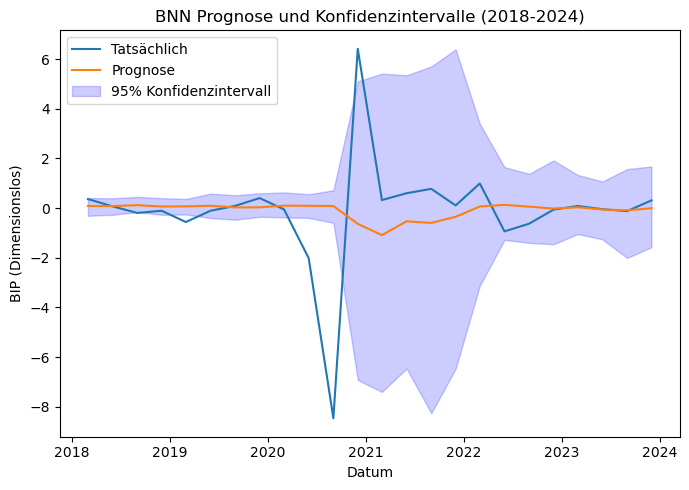

In [158]:
# Filter für BNN-Modell und Zeitraum 2015-2024
bnn_data = combined_results[
    (combined_results["model"] == "BNN") &
    (combined_results["date"] >= "2018-01-01") &
    (combined_results["date"] <= "2023-12-31")
]

plt.figure(figsize=(7, 5))
plt.plot(bnn_data["date"], bnn_data["y_true"], label="Tatsächlich")
plt.plot(bnn_data["date"], bnn_data["y_pred"], label="Prognose")
plt.fill_between(
    bnn_data["date"],
    bnn_data["lower_bound"],
    bnn_data["upper_bound"],
    color="blue",
    alpha=0.2,
    label="95% Konfidenzintervall"
)
plt.xlabel("Datum")
plt.ylabel("BIP (Dimensionslos)")
plt.title("BNN Prognose und Konfidenzintervalle (2018-2024)")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/BNN_Prognose_2015-2024_CI.png", dpi=300)
plt.show()

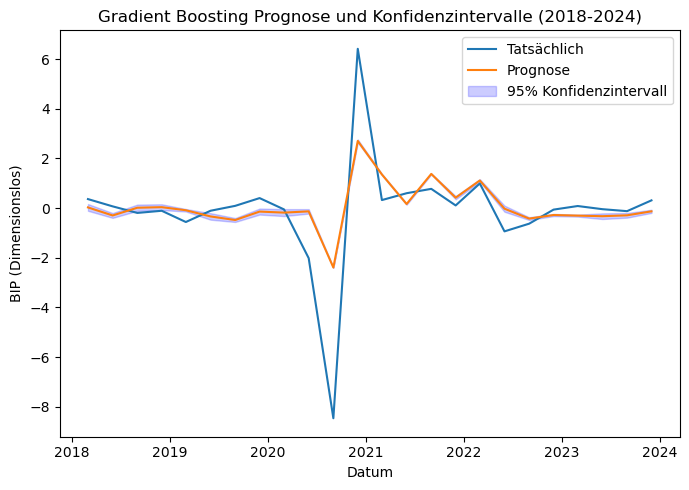

In [159]:
# Filter für BNN-Modell und Zeitraum 2015-2024
bnn_data = combined_results[
    (combined_results["model"] == "GB") &
    (combined_results["date"] >= "2018-01-01") &
    (combined_results["date"] <= "2023-12-31")
]

plt.figure(figsize=(7, 5))
plt.plot(bnn_data["date"], bnn_data["y_true"], label="Tatsächlich")
plt.plot(bnn_data["date"], bnn_data["y_pred"], label="Prognose")
plt.fill_between(
    bnn_data["date"],
    bnn_data["lower_bound"],
    bnn_data["upper_bound"],
    color="blue",
    alpha=0.2,
    label="95% Konfidenzintervall"
)
plt.xlabel("Datum")
plt.ylabel("BIP (Dimensionslos)")
plt.title("Gradient Boosting Prognose und Konfidenzintervalle (2018-2024)")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/GB_Prognose_2015-2024_CI.png", dpi=300)
plt.show()

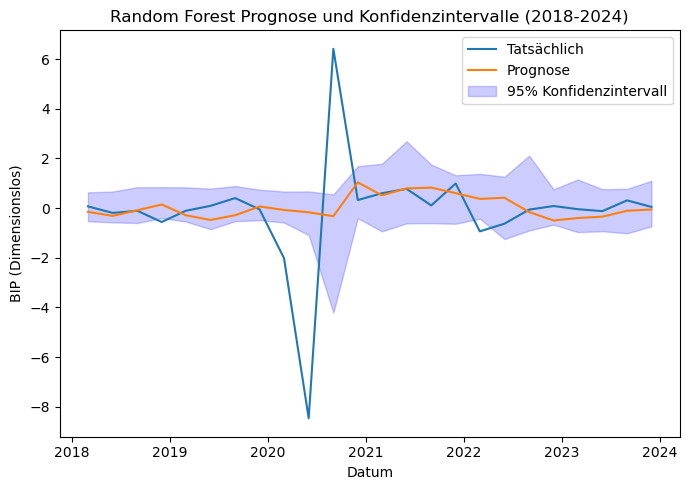

In [156]:
# Filter für BNN-Modell und Zeitraum 2015-2024
bnn_data = combined_results[
    (combined_results["model"] == "Random Forest") &
    (combined_results["date"] >= "2018-01-01") &
    (combined_results["date"] <= "2023-12-31")
]

plt.figure(figsize=(7, 5))
plt.plot(bnn_data["date"], bnn_data["y_true"], label="Tatsächlich")
plt.plot(bnn_data["date"], bnn_data["y_pred"], label="Prognose")
plt.fill_between(
    bnn_data["date"],
    bnn_data["lower_bound"],
    bnn_data["upper_bound"],
    color="blue",
    alpha=0.2,
    label="95% Konfidenzintervall"
)
plt.xlabel("Datum")
plt.ylabel("BIP (Dimensionslos)")
plt.title("Random Forest Prognose und Konfidenzintervalle (2018-2024)")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/RF_Prognose_2015-2024_CI.png", dpi=300)
plt.show()

### Für größeren Prädiktorensatz

In [ ]:
files = {
    "VAR": './Data/results/var_forecast_2_results.csv',
    "BVAR" : './Data/results/BVAR_forecast_2_results.csv',
    "GB": './Data/results/GB_forecast_results_CI_2.csv',
    "LSTM": './Data/results/lstm_forecast_results_CI.csv',
    "BNN": './Data/results/BNN_forecast_2_results.csv',
    "Random Forest": './Data/results/RF_forecast_results_CI_2.csv',
    "FF_NN": './Data/results/FF_NN_forecast_results_CI_2.csv'
}

# Container for all model results
all_results = []

for model_name, file_path in files.items():
    df = pd.read_csv(file_path)

    # Calculate residuals
    df["residual"] = df["y_pred"] - df["y_true"]

    # Add model name
    df["model"] = model_name

    # Keep only relevant columns
    df = df[["date", "model", "y_true", "y_pred", "residual", "lower_bound", "upper_bound"]]

    all_results.append(df)

# Combine all into one DataFrame
combined_results = pd.concat(all_results, ignore_index=True)

# Optional: convert date to datetime format
combined_results["date"] = pd.to_datetime(combined_results["date"])


In [133]:
rmse_list = []

for model in combined_results["model"].unique():
    model_data = combined_results[combined_results["model"] == model]
    rmse = np.sqrt(np.mean(model_data["residual"] ** 2))
    rmse_list.append({"model": model, "rmse": rmse})

# DataFrame erstellen und nach RMSE sortieren
rmse_df = pd.DataFrame(rmse_list).sort_values(by="rmse")
print(rmse_df.round(4))

           model    rmse
2             GB  0.7907
5  Random Forest  1.1371
4            BNN  1.1753
3           LSTM  1.3762
6          FF_NN  1.4822
1           BVAR  1.9939
0            VAR  2.1764


In [134]:
# RMSE ohne Krisenperioden berechnen

def ist_krisenzeitpunkt(datum):
    return any(start <= datum <= end for start, end in krisen)

rmse_list = []

for model in combined_results["model"].unique():
    model_data = combined_results[combined_results["model"] == model]
    
    # Datum als datetime konvertieren, falls noch nicht geschehen
    model_data = model_data.copy()
    model_data["date"] = pd.to_datetime(model_data["date"])

    # Zeilen entfernen, die in eine Krisenperiode fallen
    model_data = model_data[~model_data["date"].apply(ist_krisenzeitpunkt)]

    # RMSE berechnen
    rmse = np.sqrt(np.mean(model_data["residual"] ** 2))
    rmse_list.append({"model": model, "rmse": rmse})

# DataFrame erstellen und sortieren
rmse_oK_df = pd.DataFrame(rmse_list).sort_values(by="rmse")
print(rmse_oK_df.round(4))

           model    rmse
2             GB  0.2763
6          FF_NN  0.4128
5  Random Forest  0.4376
4            BNN  0.4644
3           LSTM  0.5105
1           BVAR  0.5946
0            VAR  0.6088


In [135]:
# Standardabweichung aus dem 95 %-Intervall ableiten
combined_results["sigma"] = (combined_results["upper_bound"] - combined_results["lower_bound"]) / (2 * 1.96)

# 2. Log-Score pro Zeile berechnen
combined_results["log_score"] = norm.logpdf(combined_results["y_true"], loc=combined_results["y_pred"], scale=combined_results["sigma"])

# 3. Gesamt- und Modell-Scores
overall_log_score = combined_results["log_score"].mean()          # das große Ganze
model_log_scores  = combined_results.groupby("model")["log_score"].mean()  # pro Modell

print(f"Ø Log-Score gesamt:  {overall_log_score:.3f}")
print(model_log_scores.sort_values(ascending=False))


Ø Log-Score gesamt:  -9758.162
model
Random Forest       -1.637365
BNN                 -1.714872
VAR                 -2.950290
BVAR               -14.348051
FF_NN              -25.675296
LSTM               -36.060288
GB              -68137.660634
Name: log_score, dtype: float64


In [136]:
# Log-Scores nur für Nicht-Krisenzeiten berechnen

def ist_krisenzeitpunkt(datum):
    return any(start <= datum <= end for start, end in krisen)

# Filter für Nicht-Krisenzeiten
non_crisis_results = combined_results[~combined_results["date"].apply(ist_krisenzeitpunkt)]

# Log-Score Gesamt und pro Modell
overall_log_score_nc = non_crisis_results["log_score"].mean()
model_log_scores_nc = non_crisis_results.groupby("model")["log_score"].mean()

print(f"Ø Log-Score (ohne Krisenzeiten): {overall_log_score_nc:.3f}")
print(model_log_scores_nc.sort_values(ascending=False))

Ø Log-Score (ohne Krisenzeiten): -1228.728
model
Random Forest      -0.563435
BNN                -0.794569
BVAR               -1.852227
VAR                -2.221499
LSTM              -11.203996
FF_NN             -14.921514
GB              -8582.606664
Name: log_score, dtype: float64


### Vergleich der Modelle für die EU 

In [10]:
files = {
    "EU_PRE": './Data/results/BNN_EU_results_Pre.csv',
    "DE_PRE": './Data/results/BNN_DE_results_Pre.csv',
    "FR_PRE": './Data/results/BNN_FR_results_Pre.csv',
    "IT_PRE": './Data/results/BNN_IT_results_Pre.csv',
    "EU": './Data/results/BNN_EU_results.csv',
    "DE": './Data/results/BNN_DE_results.csv',
    "FR": './Data/results/BNN_FR_results.csv',
    "IT": './Data/results/BNN_IT_results.csv',
    "VAR_EU": './Data/results/VAR_EU_results.csv',
    "VAR_DE": './Data/results/VAR_DE_results.csv',
    "VAR_FR": './Data/results/VAR_FR_results.csv',
    "VAR_IT": './Data/results/VAR_IT_results.csv',
}

# Container for all model results
all_results = []

for model_name, file_path in files.items():
    df = pd.read_csv(file_path)

    # Calculate residuals
    df["residual"] = df["pred_mean"] - df["true"]

    # Add model name
    df["model"] = model_name

    # Keep only relevant columns
    df = df[["date", "model", "true", "pred_mean", "residual", "CI_lower", "CI_upper"]]

    all_results.append(df)

# Combine all into one DataFrame
combined_results = pd.concat(all_results, ignore_index=True)

# Optional: convert date to datetime format
combined_results["date"] = pd.to_datetime(combined_results["date"])


In [11]:
rmse_list = []

for model in combined_results["model"].unique():
    model_data = combined_results[combined_results["model"] == model]
    rmse = np.sqrt(np.mean(model_data["residual"] ** 2))
    rmse_list.append({"model": model, "rmse": rmse})

# DataFrame erstellen und nach RMSE sortieren
rmse_df = pd.DataFrame(rmse_list).sort_values(by="rmse")
print(rmse_df.round(4))

     model    rmse
5       DE  1.3197
4       EU  1.4398
7       IT  1.4538
6       FR  1.4731
0   EU_PRE  1.5276
1   DE_PRE  1.5832
2   FR_PRE  1.6395
3   IT_PRE  1.7318
9   VAR_DE  1.8352
10  VAR_FR  3.1574
11  VAR_IT  3.1890
8   VAR_EU  3.6917


In [12]:
# Standardabweichung aus dem 95 %-Intervall ableiten
combined_results["sigma"] = (combined_results["CI_upper"] - combined_results["CI_lower"]) / (2 * 1.96)

# 2. Log-Score pro Zeile berechnen
combined_results["log_score"] = norm.logpdf(combined_results["true"], loc=combined_results["pred_mean"], scale=combined_results["sigma"])

# 3. Gesamt- und Modell-Scores
overall_log_score = combined_results["log_score"].mean()          # das große Ganze
model_log_scores  = combined_results.groupby("model")["log_score"].mean()  # pro Modell

print(f"Ø Log-Score gesamt:  {overall_log_score:.3f}")
print(model_log_scores.sort_values(ascending=False))


Ø Log-Score gesamt:  -18.804
model
EU_PRE    -1.938199
DE_PRE    -2.298547
FR_PRE    -2.467334
IT_PRE    -2.543983
VAR_FR    -3.629464
VAR_IT   -10.896060
VAR_EU   -18.052969
IT       -23.488972
VAR_DE   -31.915878
FR       -38.301237
DE       -41.552050
EU       -46.502137
Name: log_score, dtype: float64


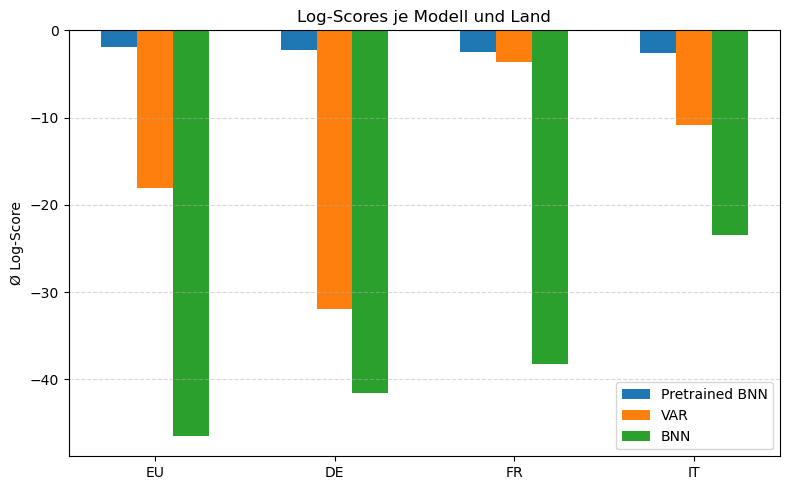

In [14]:

# Log-Score-Daten in DataFrame-Form bringen
data = {
    "EU": {"Pretrained BNN": -1.938, "VAR": -18.053, "BNN": -46.502},
    "DE": {"Pretrained BNN": -2.299, "VAR": -31.916, "BNN": -41.552},
    "FR": {"Pretrained BNN": -2.467, "VAR": -3.629,  "BNN": -38.301},
    "IT": {"Pretrained BNN": -2.544, "VAR": -10.896, "BNN": -23.489}
}

df = pd.DataFrame(data)

# Balkendiagramm
fig, ax = plt.subplots(figsize=(8, 5))
width = 0.2
x = np.arange(len(df.columns))  # Länder

# Plot je Modell
for i, model in enumerate(df.index):
    ax.bar(x + i * width, df.loc[model], width, label=model)

# Achsen & Layout
ax.set_xticks(x + width)
ax.set_xticklabels(df.columns)
ax.set_ylabel("Ø Log-Score")
ax.set_title("Log-Scores je Modell und Land")
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("./plots/Log_Scores_Models_Land.png", dpi=300)
plt.show()


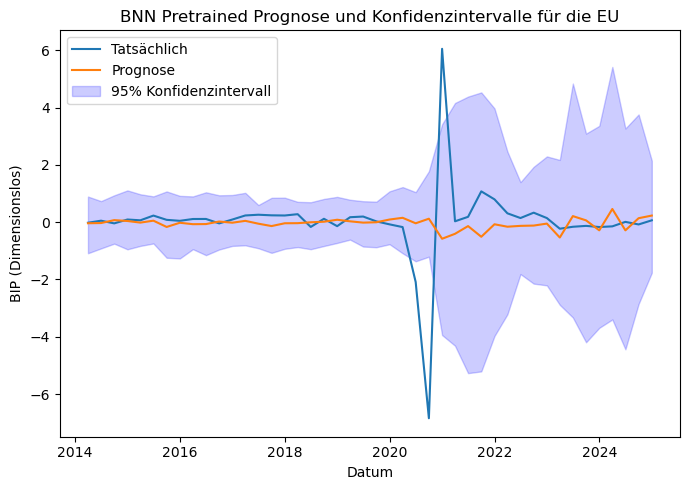

In [32]:
# Filter für BNN-Modell und Zeitraum 2015-2024
bnn_data = combined_results[
    (combined_results["model"] == "EU_PRE") ]

plt.figure(figsize=(7, 5))
plt.plot(bnn_data["date"], bnn_data["true"], label="Tatsächlich")
plt.plot(bnn_data["date"], bnn_data["pred_mean"], label="Prognose")
plt.fill_between(
    bnn_data["date"],
    bnn_data["CI_lower"],
    bnn_data["CI_upper"],
    color="blue",
    alpha=0.2,
    label="95% Konfidenzintervall"
)
plt.xlabel("Datum")
plt.ylabel("BIP (Dimensionslos)")
plt.title("BNN Pretrained Prognose und Konfidenzintervalle für die EU")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/BNN_PRE_Prognose_EU.png", dpi=300)
plt.show()

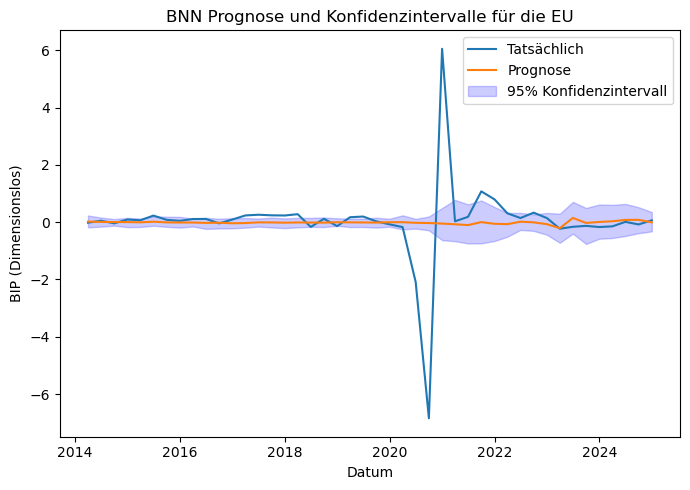

In [33]:
# Filter für BNN-Modell und Zeitraum 2015-2024
bnn_data = combined_results[
    (combined_results["model"] == "EU") ]

plt.figure(figsize=(7, 5))
plt.plot(bnn_data["date"], bnn_data["true"], label="Tatsächlich")
plt.plot(bnn_data["date"], bnn_data["pred_mean"], label="Prognose")
plt.fill_between(
    bnn_data["date"],
    bnn_data["CI_lower"],
    bnn_data["CI_upper"],
    color="blue",
    alpha=0.2,
    label="95% Konfidenzintervall"
)
plt.xlabel("Datum")
plt.ylabel("BIP (Dimensionslos)")
plt.title("BNN Prognose und Konfidenzintervalle für die EU")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/BNN_Prognose_EU.png", dpi=300)
plt.show()

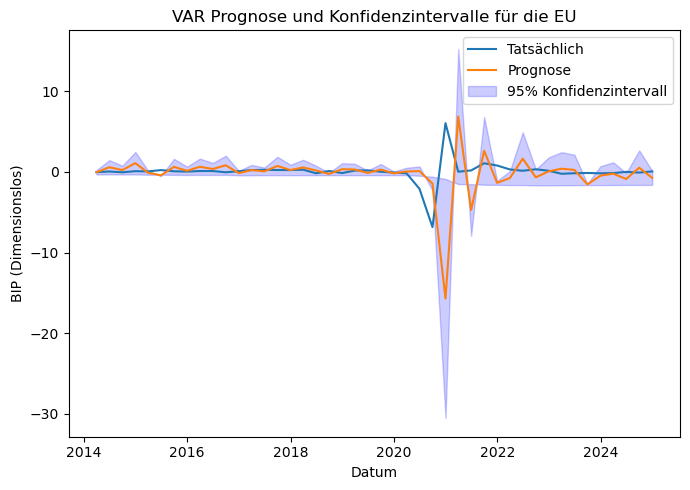

In [31]:
# Filter für BNN-Modell und Zeitraum 2015-2024
bnn_data = combined_results[
    (combined_results["model"] == "VAR_EU") ]

plt.figure(figsize=(7, 5))
plt.plot(bnn_data["date"], bnn_data["true"], label="Tatsächlich")
plt.plot(bnn_data["date"], bnn_data["pred_mean"], label="Prognose")
plt.fill_between(
    bnn_data["date"],
    bnn_data["CI_lower"],
    bnn_data["CI_upper"],
    color="blue",
    alpha=0.2,
    label="95% Konfidenzintervall"
)
plt.xlabel("Datum")
plt.ylabel("BIP (Dimensionslos)")
plt.title("VAR Prognose und Konfidenzintervalle für die EU")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/VAR_Prognose_EU.png", dpi=300)
plt.show()